In [36]:
# import
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import gym
from collections import namedtuple
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [42]:
# hyper-params
GAMMA = .9
LEARNING_RATE = .01
EXPERIENCE_CAPACITY = 2000
UPDATE_FREQUENCY = 100
MAX_EPI = 400
MAX_STEP = 200
BATCH_SIZE = 32
EPSILON = .1
N_STATES = 4
N_ACTIONS = 2

In [43]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [44]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 10)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(10, N_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [45]:
# functions
def choose_action(bahavior_network, o):
    if random.random()<EPSILON:
        return random.randint(0, N_ACTIONS-1)
    else:
        action = behavior_network(Variable(Tensor(o).unsqueeze(0))).max(1)[1]        
        return action.data[0][0]

def learn(target_network, behavior_network, exp, optimizer):
    # batch
    minibatch = exp.sample(BATCH_SIZE)
    minibatch = Transition(*zip(*minibatch))
    s_batch = Variable(Tensor(minibatch.state))
    a_batch = Variable(LongTensor(minibatch.action).unsqueeze(1))
    r_batch = Variable(Tensor(minibatch.reward))
    s_next_batch = Variable(Tensor(minibatch.next_state))
    
    # loss
    s_eval = behavior_network(s_batch).gather(1, a_batch)
    s_next_eval = target_network(s_next_batch).max(1)[0]
    Gt = r_batch + GAMMA * s_next_eval    
    Gt.detach_()
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(s_eval, Gt)
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def update_param(target_network, behavior_network):
    target_network.load_state_dict(behavior_network.state_dict())

[2017-07-29 11:23:10,919] Making new env: CartPole-v0


n: 0, epi: 49, steps: 17
n: 0, epi: 99, steps: 80
n: 0, epi: 149, steps: 200
n: 0, epi: 199, steps: 115
n: 0, epi: 249, steps: 163
n: 0, epi: 299, steps: 200
n: 0, epi: 349, steps: 155
n: 0, epi: 399, steps: 200
n: 1, epi: 49, steps: 194
n: 1, epi: 99, steps: 169
n: 1, epi: 149, steps: 153
n: 1, epi: 199, steps: 200
n: 1, epi: 249, steps: 117
n: 1, epi: 299, steps: 200
n: 1, epi: 349, steps: 200
n: 1, epi: 399, steps: 111
n: 2, epi: 49, steps: 38
n: 2, epi: 99, steps: 121
n: 2, epi: 149, steps: 9
n: 2, epi: 199, steps: 180
n: 2, epi: 249, steps: 110
n: 2, epi: 299, steps: 133
n: 2, epi: 349, steps: 128
n: 2, epi: 399, steps: 28
n: 3, epi: 49, steps: 15
n: 3, epi: 99, steps: 18
n: 3, epi: 149, steps: 145
n: 3, epi: 199, steps: 18
n: 3, epi: 249, steps: 20
n: 3, epi: 299, steps: 47
n: 3, epi: 349, steps: 27
n: 3, epi: 399, steps: 200
n: 4, epi: 49, steps: 29
n: 4, epi: 99, steps: 55
n: 4, epi: 149, steps: 199
n: 4, epi: 199, steps: 127
n: 4, epi: 249, steps: 63
n: 4, epi: 299, steps: 110

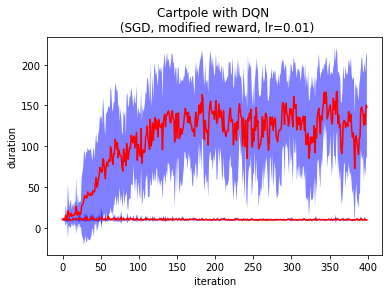

In [57]:
# main
env = gym.make('CartPole-v0')
env = env.unwrapped

N_REPEAT = 10
record = np.zeros((N_REPEAT, MAX_EPI))

for n in xrange(N_REPEAT):
    behavior_network = DQN()
    target_network = DQN()
    if use_cuda:
        behavior_network.cuda()
        target_network.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optimizer = optim.Adam(behavior_network.parameters(), lr=LEARNING_RATE)
    learning_counter = 0
    
    # main loop
    for epi in xrange(MAX_EPI):    
        o = env.reset()
        count = 0
        for t in xrange(MAX_STEP):
            count += 1
        
            a = choose_action(behavior_network, o)
            o_next, r, done, info = env.step(a)      
        
            # sophisticated reward
            x, x_dot, theta, theta_dot = o_next
            r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
            r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
            r = r1 + r2
            
            # slightly modified reward
            #if done:
            #    r = -10
        
            exp.push(o, a, r, o_next)
            o = o_next
            # update behavior network every step
            learn(target_network, behavior_network, exp, optimizer)
            learning_counter += 1
            # update target network every UPDATE_FREQUENCY step
            if(learning_counter%UPDATE_FREQUENCY==UPDATE_FREQUENCY-1):
                update_param(target_network, behavior_network)
    
            if done:
                break
        if epi%50==49:
            print 'n: {}, epi: {}, steps: {}'.format(n, epi, count)
        record[n][epi] = count

mu = record.mean(axis=0)
sigma = record.std(axis=0)
lower_bound = mu-sigma
upper_bound = mu+sigma

plt.plot(xrange(MAX_EPI), mu, color='red')
plt.fill_between(xrange(MAX_EPI), lower_bound, upper_bound, facecolor='blue', alpha=0.5)
plt.title('Cartpole with DQN \n (SGD, modified reward, lr=0.01)')
plt.xlabel('iteration')
plt.ylabel('duration')
#plt.savefig('2')
plt.show()

In [58]:

plt.plot(xrange(MAX_EPI), mu, color='red')
plt.fill_between(xrange(MAX_EPI), lower_bound, upper_bound, facecolor='blue', alpha=0.5)
plt.title('Cartpole with DQN \n (adam, slightly modified reward, lr=0.01)')
plt.xlabel('iteration')
plt.ylabel('duration')
plt.savefig('02')